Analysing who is healed and when by each medic.

In [4]:
## Imports

# The library generated by rust
# TODO: ent.PlayerState is not recognized, but ent.Player is ?
import tf2dal as dal
from tf2dal import entities as ent, events as evt, demo, math, game

# If any of these fail, use "!pip install <package>" to install via pip
import numpy as np
#import pyarrow # for pandas 3.0
import pandas as pd
import matplotlib.pyplot as plt
import kmapper as km

Information for `demos/demofile.dem`:
- Acquired from [demos.tf/1042159](https://demos.tf/1042159) 
- Associated log at [logs.tf/3501742](https://logs.tf/3501742)

Round data for demofile.dem should be approximately as follows (from log):

| Round | Time | Kills | Winner |
|-------|------|-------|--------|
| 0     | 3:37 | 19    | Red    |
| 1     | 2:41 | 21    | Red    |
| 2     | 8:23 | 47    | Blue   |
| 3     | 2:05 | 9     | Red    |
| 4     | 2:17 | 23    | Red    |
| 5     | 4:34 | 33    | Red    |

In [2]:
rounds_data = dal.load_demo_rounds("demos/demofile.dem")
print(f"Loaded {len(rounds_data)} round(s)")

for i, rnd in enumerate(rounds_data):
    time = 0.0
    for tick, state in rnd.tick_states.items():
        time += state.tick_delta
    print("Round %d: %2d:%5.2f (%f) | %2d Kills | %5d States | %5d Ticks | Winner: %s" % (
        i, int(np.floor(time/60)), time - np.floor(time/60) * 60, time,
        len(rnd.kills),
        len(rnd.tick_states),
        rnd.rounds[0].end_tick - rnd.rounds[0].start_tick,
        rnd.rounds[0].winner
    ))

Loaded 6 round(s)
Round 0:  3:36.45 (216.449995) | 19 Kills | 14430 States | 14434 Ticks | Winner: Team.Red
Round 1:  2:41.74 (161.744996) | 21 Kills | 10783 States | 10785 Ticks | Winner: Team.Red
Round 2:  8:22.24 (502.244989) | 47 Kills | 33483 States | 33485 Ticks | Winner: Team.Blue
Round 3:  2: 5.23 (125.234997) |  9 Kills |  8349 States |  8352 Ticks | Winner: Team.Red
Round 4:  2:15.75 (135.749997) | 23 Kills |  9050 States |  9135 Ticks | Winner: Team.Red
Round 5:  4:32.52 (272.519994) | 33 Kills | 18168 States | 18277 Ticks | Winner: Team.Red


Possible table values

- Is Medic
- Being Healed, No Critheals
- Being Healed, With Critheals
- Not Being Healed, No Critheals
- Not Being Healed, With Critheals
- Dead
- No Medic Alive

In [5]:
def critheal_percent(tslh):
    # 1 = has full critheals. 0 = no crit heals.
    return max(0, min((tslh - 10.0) / 5.0, 1))

def heal_rate(critheal_perc):
    # 24hp/s base, 72 hp/s when fully at crit heals
    return 48 * critheal_perc + 24

# [(heal status tick 1), (tick 2), ...]
round_red_heal_statuses = []
round_blu_heal_statuses = []

IS_MEDIC = 0
HEALED_NO_CRITS = 1
HEALED_CRITS = 2
NOT_HEALED_NO_CRITS = 3
NOT_HEALED_CRITS = 4
DEAD = 5
NO_MEDIC = 6

def get_healstates(tick, data: demo.TickData):
    # Return:
    # ((tick, red player 1, red player 2, ...), (tick blue player 1, blue player 2, ...))

    red = [player for player in data.players if player.team == game.Team.Red]
    blu = [player for player in data.players if player.team == game.Team.Blue]

    i = 0
    ret = []
    for team in [red, blu]:
        i += 1
        team_statuses = [tick]
        medics = [p for p in team if p.player_class == game.Class.Medic]
        if len(medics) == 0 or True not in [m.state == 0 for m in medics]:
            print(f"({i}) medic dead")
            team_statuses.extend([NO_MEDIC for _ in team])
            ret.append(team_statuses)
            continue

        for player in team:
            if player.state != 0:
                #print(f"({i}) +1 dead player")
                team_statuses.append(DEAD)
                continue
            if player.player_class == game.Class.Medic:
                #print(f"({i}) +1 medic")
                team_statuses.append(IS_MEDIC)
                continue
            
            has_crits = critheal_percent(player.time_since_last_hurt) > 0
            being_healed = False
            for medigun in data.mediguns:
                if player.info.entity_id == medigun.heal_target and medigun.is_healing and not medigun.is_holstered:
                    being_healed = True
                    #print(f"({i}) +1 being healed")
                    team_statuses.append(HEALED_CRITS if has_crits else HEALED_NO_CRITS)
                    break
            
            if not being_healed:
                #print(f"({i}) +1 not being healed")
                team_statuses.append(NOT_HEALED_CRITS if has_crits else NOT_HEALED_NO_CRITS)
            
        ret.append(team_statuses)
    
    return ret


for (tick, data) in rounds_data[0].tick_states.items():
    statuses = get_healstates(tick, data)
    if len(statuses[0]) != 7 or len(statuses[1]) != 7:
        print(f"{len(statuses[0])}, {len(statuses[1])}")
        
    round_red_heal_statuses.append(statuses[0])
    round_blu_heal_statuses.append(statuses[1])

   

(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic dead
(2) medic 

In [6]:
blu_byplayer = np.sort(np.asarray(round_blu_heal_statuses), axis=0).transpose()
red_byplayer = np.sort(np.asarray(round_red_heal_statuses), axis=0).transpose()

In [7]:
total_ticks = len(round_red_heal_statuses)

for i in range(1, 7):
    num_medic = 0
    num_dead = 0
    num_crithealed = 0
    num_slowhealed = 0
    num_critswasted = 0
    num_normal = 0
    num_nomedic = 0

    for status in gobyplayer[i]:
        if status == IS_MEDIC:
            num_medic += 1
        if status == DEAD:
            num_dead += 1
        if status == HEALED_CRITS:
            num_crithealed += 1
        if status == HEALED_NO_CRITS:
            num_slowhealed += 1
        if status == NOT_HEALED_NO_CRITS:
            num_normal += 1
        if status == NOT_HEALED_CRITS:
            num_critswasted += 1
        if status == NO_MEDIC:
            num_nomedic += 1

    print(f"Blu Player {i}:")
    print(f"- Ticks as Medic    : {num_medic} ({float(num_medic*100) / total_ticks}%)")
    print(f"- Ticks w/ No Medic : {num_nomedic} ({float(num_nomedic*100) / total_ticks}%)")
    print(f"- Ticks Crit Healed : {num_crithealed} ({float(num_crithealed*100) / total_ticks}%)")
    print(f"- Ticks Slow Healed : {num_slowhealed} ({float(num_slowhealed*100) / total_ticks}%)")
    print(f"- Ticks Crit Wasted : {num_critswasted} ({float(num_critswasted*100) / total_ticks}%)")
    print(f"- Ticks Normal      : {num_normal} ({float(num_normal*100) / total_ticks}%)")
    print(f"- Ticks Dead        : {num_dead} ({float(num_dead*100) / total_ticks}%)")

NameError: name 'gobyplayer' is not defined

In [8]:
category_names = [
    "Playing Medic",
    "Slow Healed",
    "Crit Healed",
    "Normal",
    "Crit Wasted",
    "Dead"
    "No Medic",
]

def create_results(teamresults):
    ret = {}
    for i in range(1,7):
        uniq = np.unique(teamresults[i], return_counts=True)
        print(f"{uniq[0]}, {uniq[1]}")

        ptitle = f"Player {i}"
        ret[ptitle] = [0 for _ in range(0, 7)]
        for n, j in enumerate(uniq[0]):
            ret[ptitle][j] = round(float(uniq[1][n]) * 100 / total_ticks, 2)
    return ret

red_results = create_results(red_byplayer)
blu_results = create_results(blu_byplayer)

[1 2 3 4 5], [1533 1207 3138 7159 1393]
[0], [14430]
[1 2 3 4 5], [1380  401 8136 3134 1379]
[1 2 3 4 5], [1433  741 8345 2913  998]
[1 2 3 4], [1735 2047 4478 6170]
[1 2 3 4 5], [ 250  713 2908 6945 3614]
[1 2 3 4 5 6], [1833  945 2988 5852 1506 1306]
[0 6], [13124  1306]
[1 2 3 4 5 6], [ 692  110 6094 2464 3764 1306]
[1 2 3 4 5 6], [2879 1943 3377 2590 2335 1306]
[1 2 3 4 5 6], [ 438  782 3371 5978 2555 1306]
[1 2 3 4 5 6], [1113  187 6034 2250 3540 1306]


In [9]:
blu_results

{'Player 1': [0, 12.7, 6.55, 20.71, 40.55, 10.44, 9.05],
 'Player 2': [90.95, 0, 0, 0, 0, 0, 9.05],
 'Player 3': [0, 4.8, 0.76, 42.23, 17.08, 26.08, 9.05],
 'Player 4': [0, 19.95, 13.47, 23.4, 17.95, 16.18, 9.05],
 'Player 5': [0, 3.04, 5.42, 23.36, 41.43, 17.71, 9.05],
 'Player 6': [0, 7.71, 1.3, 41.82, 15.59, 24.53, 9.05]}

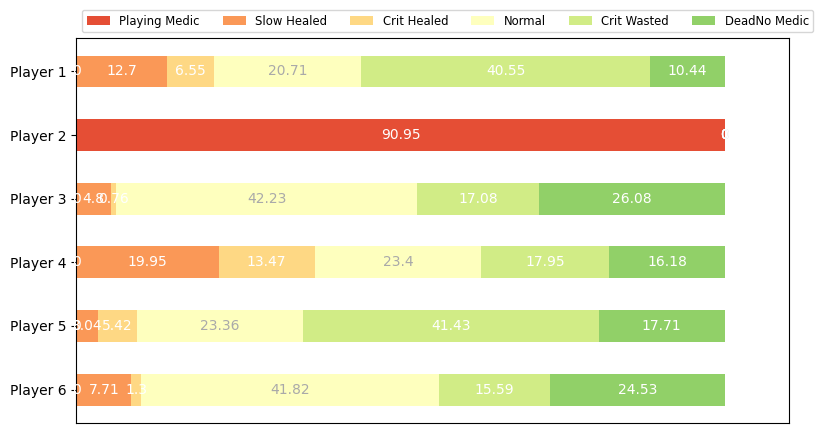

In [10]:
def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncols=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax

survey(blu_results, category_names)
plt.show()